In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os

In [3]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [4]:
import alpaca_trade_api as tradeapi # Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY_ID")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY") # Initialize the API
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
list_of_tickers = ["SPY", "AGG"]
# YOUR CODE HERE
start_date = datetime.now().date()
end_date = start_date - timedelta(365)

prices = api.get_barset(
    list_of_tickers,
    '1D',
    limit=365,
    start=start_date,
    end=end_date
)

In [6]:
# Create SPY dataframe
SPY_prices = prices['SPY'].df

# Create AGG dataframe
AGG_prices = prices['AGG'].df

# Drop unncessary columns and fix index
SPY_prices = SPY_prices.drop(columns=['open', 'high', 'low', 'volume'])
SPY_prices.index = SPY_prices.index.date

AGG_prices = AGG_prices.drop(columns=['open', 'high', 'low', 'volume'])
AGG_prices.index = AGG_prices.index.date

# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [7]:
# Calculate the daily roi for the stocks
# YOUR CODE HERE

SPY_daily_returns = SPY_prices.pct_change()
SPY_daily_returns.dropna(inplace=True)

AGG_daily_returns = AGG_prices.pct_change()
AGG_daily_returns.dropna(inplace=True)

In [8]:
# Calculate volatility
# YOUR CODE HERE
SPY_std = SPY_daily_returns['close'].std()
AGG_std = AGG_daily_returns['close'].std()

# Also store means
SPY_mean = SPY_daily_returns['close'].mean()
AGG_mean = AGG_daily_returns['close'].mean()

In [9]:
# Save the last day's closing price
# YOUR CODE HERE
SPY_last_close = SPY_prices.iloc[-1]['close']

AGG_last_close = AGG_prices.iloc[-1]['close']

In [20]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30

In [22]:
##### Run the Monte Carlo Simulation
monte_carlo = pd.DataFrame()
monte_carlo.index.name = "Record"
sims_dict = {}

for x in range(number_simulations):
    
    # YOUR CODE HERE
    SPY_sims = [SPY_last_close]
    AGG_sims = [AGG_last_close]
    
    for _ in range(number_records):
        SPY_sim = SPY_sims[-1] * (1 + np.random.normal(SPY_mean, SPY_std))
        AGG_sim = AGG_sims[-1] * (1 + np.random.normal(AGG_mean, AGG_std))
        
        SPY_sims.append(SPY_sim)
        AGG_sims.append(AGG_sim)
        
    price_sims = pd.DataFrame({'SPY': SPY_sims, 'AGG': AGG_sims})
    
    sim_daily_returns = price_sims.pct_change()
    
    weights = [0.60, 0.40]
    
    portfolio_daily_returns = sim_daily_returns.dot(weights).fillna(0)
    
    portfolio_cumulative_returns = (1 + portfolio_daily_returns).cumprod()

    monte_carlo[f"Simulation {x}"] = portfolio_cumulative_returns

monte_carlo.head()

,Simulation 0,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,...,Simulation 490,Simulation 491,Simulation 492,Simulation 493,Simulation 494,Simulation 495,Simulation 496,Simulation 497,Simulation 498,Simulation 499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001384,0.976167,1.001718,0.991753,0.999094,0.980132,0.982758,1.023946,0.984820,1.019729,...,1.008942,1.008357,0.991773,0.996158,1.017250,0.994383,1.001902,0.990883,0.996734,0.988497
2,1.001512,0.965759,1.006092,0.975163,0.996257,0.978935,0.992192,1.019035,0.977617,1.021577,...,1.008363,0.994552,0.995701,0.985996,1.038717,0.996192,0.983095,0.993361,0.995437,0.996704
3,0.994064,0.936163,0.995376,0.980318,0.988109,0.976629,1.001571,1.014304,0.962794,1.018566,...,1.008508,1.009121,0.988609,0.988908,1.050025,1.012416,0.993789,0.996731,1.013182,0.998729
4,0.985636,0.940758,1.004630,0.971950,0.995869,0.954868,1.003449,1.017678,0.941579,1.030660,...,1.014710,1.035841,1.001437,0.977254,1.056154,1.010827,0.986030,0.999200,1.006424,0.996938


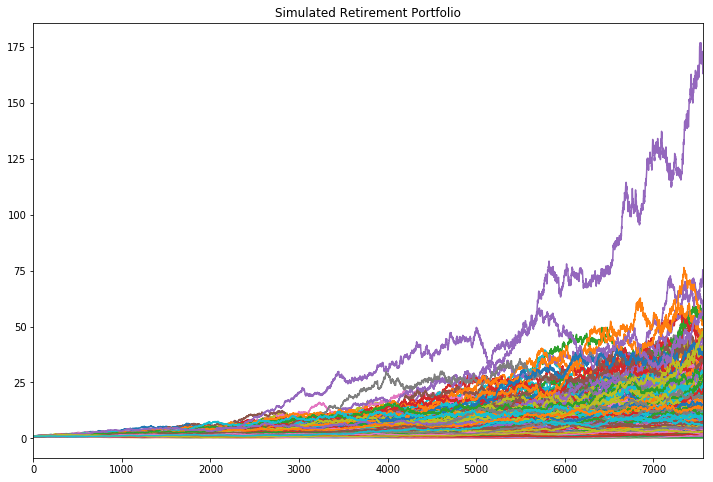

In [23]:
###### Visualize the Simulation
# YOUR CODE HERE
monte_carlo.plot(legend=None, title="Simulated Retirement Portfolio", figsize=(12,8))

In [26]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
# YOUR CODE HERE
cumulative_returns_30_years = monte_carlo.iloc[-1]
cumulative_returns_30_years.head()

Simulation 0     9.855337
Simulation 1    30.222044
Simulation 2     1.229393
Simulation 3    12.638125
Simulation 4    20.891814
Name: 7560, dtype: float64

In [25]:
# Display the 90% confidence interval for the ending returns
# YOUR CODE HERE
conf_interval = cumulative_returns_30_years.quantile(q=[0.05, 0.95])
conf_interval

0.05     1.554670
0.95    36.475881
Name: 7560, dtype: float64

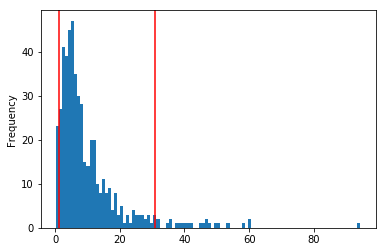

In [36]:
# Visualize the distribution of the ending returns
# YOUR CODE HERE
plt.figure()
cumulative_returns_30_years.plot(kind='hist', bins=100)
plt.axvline(conf_interval.iloc[0], color='r')
plt.axvline(conf_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [37]:
# YOUR CODE HERE
# cumulative_returns_30_years.value_counts(bins=10) / len(cumulative_returns_30_years)
percentiles = cumulative_returns_30_years.quantile([0.1, 0.5, 0.9])

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [38]:
# YOUR CODE HERE
initial_investment = 20000

portfolio_returns_10th_percentile = initial_investment * percentiles.loc[0.1]

portfolio_returns_50th_percentile = initial_investment * percentiles.loc[0.5]

portfolio_returns_90th_percentile = initial_investment * percentiles.loc[0.9]

### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [41]:
# YOUR CODE HERE
projected_income = 6085

portfolio_returns_10th_percentile * 0.04

1758.7960630290108

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [43]:
# YOUR CODE HERE
larger_investment = initial_investment * 1.5

returns_from_larger_investment = larger_investment * percentiles.loc[0.1]

returns_from_larger_investment * 0.04

2638.1940945435163

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# YOUR CODE HERE